In [2]:
# from: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html

In [3]:
import numpy as np
import xgboost
from sklearn.linear_model import LinearRegression

import shap

In [4]:
N = 2_000
X = np.zeros((N, 5))

X[:1_000, 0] = 1

X[:500, 1] = 1
X[1_000:1_500, 1] = 1

X[:250, 2] = 1
X[500:750, 2] = 1
X[1_000:1_250, 2] = 1
X[1_500:1_750, 2] = 1

# mean-center the data
X[:, 0:3] -= 0.5

y = 2 * X[:, 0] - 3 * X[:, 1]

In [5]:
np.cov(X.T)

array([[0.25012506, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.25012506, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.25012506, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [6]:
X.mean(axis=0)

array([0., 0., 0., 0., 0.])

In [7]:
# train a model with single tree
Xd = xgboost.DMatrix(X, label=y)
model = xgboost.train({"eta": 1, "max_depth": 3, "base_score": 0, "lambda": 0}, Xd, 1)

print("Model error =", np.linalg.norm(y - model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])

Model error = 0.0
0:[f1<0.5] yes=1,no=2,missing=2,gain=4500,cover=2000
	1:[f0<0.5] yes=3,no=4,missing=4,gain=1000,cover=1000
		3:leaf=0.5,cover=500
		4:leaf=2.5,cover=500
	2:[f0<0.5] yes=5,no=6,missing=6,gain=1000,cover=1000
		5:leaf=-2.5,cover=500
		6:leaf=-0.5,cover=500



## Shapley Values

In [8]:
pred = model.predict(Xd, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

0.0

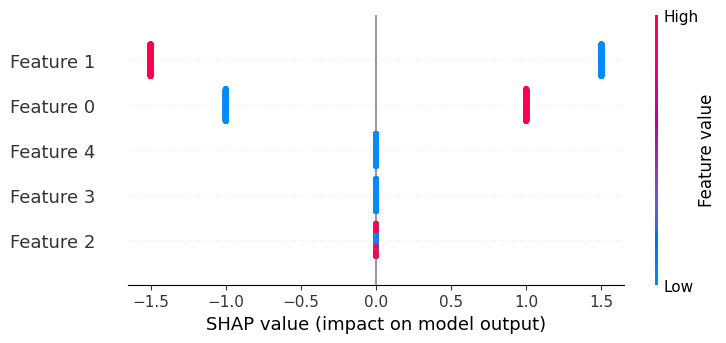

In [9]:
shap.plots.beeswarm(explanation)


In [11]:
lr = LinearRegression()
lr.fit(X, y)
lr_pred = lr.predict(X)
lr.coef_.round(2)

array([ 2., -3.,  0.,  0.,  0.])

In [12]:
main_effect_shap_values = lr.coef_ * (X - X.mean(0))
np.linalg.norm(shap_values - main_effect_shap_values)

3.4697834078323924e-13